In [2]:
import gradio as gr
import numpy as np
import IPython
from IPython.display import Audio, display
import torch
import librosa, librosa.display
from tqdm import tqdm

# import sys  
# sys.path.insert(0, '../')
from audioldm2 import text_to_audio, build_model, seed_everything
from audioldm2.latent_diffusion.modules.diffusionmodules.util import (
    make_ddim_sampling_parameters,
    make_ddim_timesteps,
    noise_like,
    extract_into_tensor,
)
from audioldm2.latent_diffusion.models.ddim import DDIMSampler

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
%reload_ext autoreload

In [5]:
%matplotlib inline

In [6]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [7]:
audioldm = None
current_model_name = None

model_name = 'audioldm_16k_crossattn_t5' # doesnt work very well? But the only thing that fits on my machine
# model_name = 'audioldm2-full' # Needs more memory than what I have
# model_name = 'audioldm_48k'

latent_diffusion=build_model(model_name=model_name)

Loading AudioLDM-2: audioldm_16k_crossattn_t5
Loading model on cuda:0
{'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'mel': {'n_mel_channels': 64, 'mel_fmin': 0, 'mel_fmax': 8000}}, 'augmentation': {'mixup': 0}, 'model': {'target': 'audioldm2.latent_diffusion.models.ddpm.LatentDiffusion', 'params': {'first_stage_config': {'base_learning_rate': 8e-06, 'target': 'audioldm2.latent_encoder.autoencoder.AutoencoderKL', 'params': {'sampling_rate': 16000, 'batchsize': 4, 'monitor': 'val/rec_loss', 'image_key': 'fbank', 'subband': 1, 'embed_dim': 8, 'time_shuffle': 1

/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


DiffusionWrapper has 265.53 M params.


/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [8]:
def noise_to_mel_to_wave(predicted_noise):
    mel = latent_diffusion.decode_first_stage(predicted_noise)
    waveform = latent_diffusion.mel_spectrogram_to_waveform(
        mel, savepath="", bs=None, name="somename", save=False
    )
    return waveform

In [9]:
plt.close()

In [74]:
latent_t_per_second=25.6
sample_rate=16000
duration = 10.0 #Duration is minimum 10 secs. The generated sounds are weird for <10secs
guidance_scale = 7
random_seed = 45
n_candidates = 1
batch_size = 1
ddim_steps = 200

fbank = torch.zeros((batch_size, 1024, 64))
stft = torch.zeros((batch_size, 1024, 512))
waveform = torch.zeros((batch_size, 160000))

seed_everything(int(random_seed))
x_T = torch.randn((1, 8, 256, 16), device="cuda")

latent_diffusion.latent_t_size = int(duration * latent_t_per_second)

In [105]:
def plot(waveform, predicted_noise, predicted_uncond_noise):
    epsilon_noise = noise_to_mel_to_wave(predicted_noise)
    epsilon_noise_uncond = noise_to_mel_to_wave(predicted_uncond_noise)
    
    IPython.display.display(IPython.display.Audio(waveform[0][0], rate=16000))
    IPython.display.display(IPython.display.Audio(epsilon_noise[0][0], rate=16000))
    IPython.display.display(IPython.display.Audio(epsilon_noise_uncond[0][0], rate=16000))
    
    %matplotlib inline
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[0])
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(epsilon_noise[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[1])
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(epsilon_noise_uncond[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[2])
    
    torch.norm(predicted_noise), torch.norm(predicted_uncond_noise)

def plot_wavs(wav1, wav2):
    IPython.display.display(IPython.display.Audio(wav1[0][0], rate=16000))
    IPython.display.display(IPython.display.Audio(wav2[0][0], rate=16000))

    %matplotlib inline
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(wav1[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[0])
    axs[0].set_title('wav1') 
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(wav2[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[1])
    axs[1].set_title('wav2') 

In [134]:
def sample_diffusion_with_sega(batch):
    with torch.no_grad():

        text_conditioning = batch["text"]
        semantic_edit_conditioning = batch["semantic_edit_text"]
        

        shape = (latent_diffusion.channels, latent_diffusion.latent_t_size, latent_diffusion.latent_f_size)
        device=latent_diffusion.device
        eta=1.0
        temperature = 1.0
        noise = noise_like(x_T.shape, device, repeat=False) * temperature

        #text conditioning
        cond_dict = {}
        for cond_model_key in latent_diffusion.cond_stage_model_metadata.keys():
            cond_stage_key = latent_diffusion.cond_stage_model_metadata[cond_model_key]["cond_stage_key"]
            cond_dict[cond_model_key] = latent_diffusion.get_learned_conditioning(text_conditioning, key=cond_model_key, unconditional_cfg=False)

        #unconditional for CFG
        uncond_dict = {}
        model_idx = 0 #default to the first in the cond list.
        for key in latent_diffusion.cond_stage_model_metadata:
            uncond_dict[key] = latent_diffusion.cond_stage_models[model_idx].get_unconditional_condition(batch_size)

        #SEGA
        semantic_cond_dict = {}
        for cond_model_key in latent_diffusion.cond_stage_model_metadata.keys():
            cond_stage_key = latent_diffusion.cond_stage_model_metadata[cond_model_key]["cond_stage_key"]
            semantic_cond_dict[cond_model_key] = latent_diffusion.get_learned_conditioning(semantic_edit_conditioning, key=cond_model_key, unconditional_cfg=False)
        
        
        
        
        ddim_sampler = DDIMSampler(latent_diffusion, device=device)
        ddim_sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=eta, verbose=False)
        
       
        x_init = x_T
        timesteps = ddim_sampler.ddim_timesteps


        intermediates = {"x_prev": [x_init], "predicted_noise_orig": [x_init], "predicted_noise_sega": [x_init]}
        time_range = np.flip(timesteps)
        total_steps = timesteps.shape[0]
        print(f"Running DDIM Sampling with {total_steps} timesteps")
        iterator = tqdm(time_range, desc="DDIM Sampler", total=total_steps)
    
        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            t_in = torch.full((batch_size,), step, device=device, dtype=torch.long)
    
            #from p_sample_ddim
            model_uncond = ddim_sampler.model.apply_model(x_init, t_in, uncond_dict) #Unconditioned epsilon estimate
            model_cond = ddim_sampler.model.apply_model(x_init, t_in, cond_dict) #Conditioned epsilon estimate
            model_semantic_cond = ddim_sampler.model.apply_model(x_init, t_in, semantic_cond_dict) #Conditioned epsilon estimate


            semantic_edit_level = 1
            semantic_quantile = 0.15 #95% quantile

            phi = model_semantic_cond - model_uncond

            model_semantic_cond_q = torch.quantile(torch.abs(phi), semantic_quantile, dim=3, keepdim=False) 
            model_semantic_cond_edited = torch.where(
                            torch.abs(phi) >= model_semantic_cond_q[:, :, :, None],
                            phi,
                            torch.zeros_like(phi),
                        )

            model_semantic_cond_edited = torch.where(
                            torch.abs(model_semantic_cond_edited) >= semantic_edit_level,
                            model_semantic_cond_edited,
                            torch.zeros_like(model_semantic_cond_edited))

            # print(torch.norm(model_semantic_cond_edited))
            

            # CFG; model_output is the estimated error after CFG
            e_t = model_uncond + guidance_scale * (model_cond - model_uncond)
            if i > 120 and i < 170:
                e_t_sega = model_uncond + (guidance_scale * (model_cond - model_uncond)) + (model_semantic_cond_edited * (model_semantic_cond - model_uncond))
            else:
                e_t_sega = model_uncond + (guidance_scale * (model_cond - model_uncond))# + (model_semantic_cond_edited * (model_semantic_cond - model_uncond))

        
            alphas = ddim_sampler.ddim_alphas
            alphas_prev = ddim_sampler.ddim_alphas_prev
    
            sqrt_one_minus_alphas = ddim_sampler.ddim_sqrt_one_minus_alphas
            sigmas = ddim_sampler.ddim_sigmas
            
            # select parameters corresponding to the currently considered timestep
            a_t = torch.full((batch_size, 1, 1, 1), alphas[index], device=device)
            a_prev = torch.full((batch_size, 1, 1, 1), alphas_prev[index], device=device)
            sigma_t = torch.full((batch_size, 1, 1, 1), sigmas[index], device=device)
            sqrt_one_minus_at = torch.full((batch_size, 1, 1, 1), sqrt_one_minus_alphas[index], device=device)
    
            noise = sigma_t * noise_like(x_T.shape, device, repeat=False) * temperature
            
            pred_x0_orig = (x_init - sqrt_one_minus_at * e_t) / a_t.sqrt()
            dir_xt_orig = (1.0 - a_prev - sigma_t**2).sqrt() * e_t
            x_prev_orig = a_prev.sqrt() * pred_x0_orig + dir_xt_orig + noise

            pred_x0 = (x_init - sqrt_one_minus_at * e_t_sega) / a_t.sqrt()
            dir_xt = (1.0 - a_prev - sigma_t**2).sqrt() * e_t_sega
            x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
            
            
            
    
            x_init = x_prev
            #return x_prev, pred_x0, e_t, model_uncond => img, pred_x0, predicted_noise, predicted_uncond_noise
    
            log_every_t = 10
            if index % log_every_t == 0 or index == total_steps - 1:
                intermediates["x_prev"].append(x_prev)
                intermediates["predicted_noise_orig"].append(e_t)
                intermediates["predicted_noise_sega"].append(e_t_sega)
    
        mel_orig = latent_diffusion.decode_first_stage(x_prev_orig)
        waveform_orig = latent_diffusion.mel_spectrogram_to_waveform(
            mel_orig, savepath="", bs=None, name="", save=False
        )
        
        mel_sega = latent_diffusion.decode_first_stage(x_prev)
        waveform_sega = latent_diffusion.mel_spectrogram_to_waveform(
            mel_sega, savepath="", bs=None, name="", save=False
        )
        return mel_sega, waveform_sega, model_cond, model_uncond, mel_orig, waveform_orig, model_semantic_cond, e_t, intermediates 
        #=> mel of estimated z; wav of estimated z; predicted noise (epsilon); predicted noise unconditional; predicted noise with CFG

Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.66it/s]


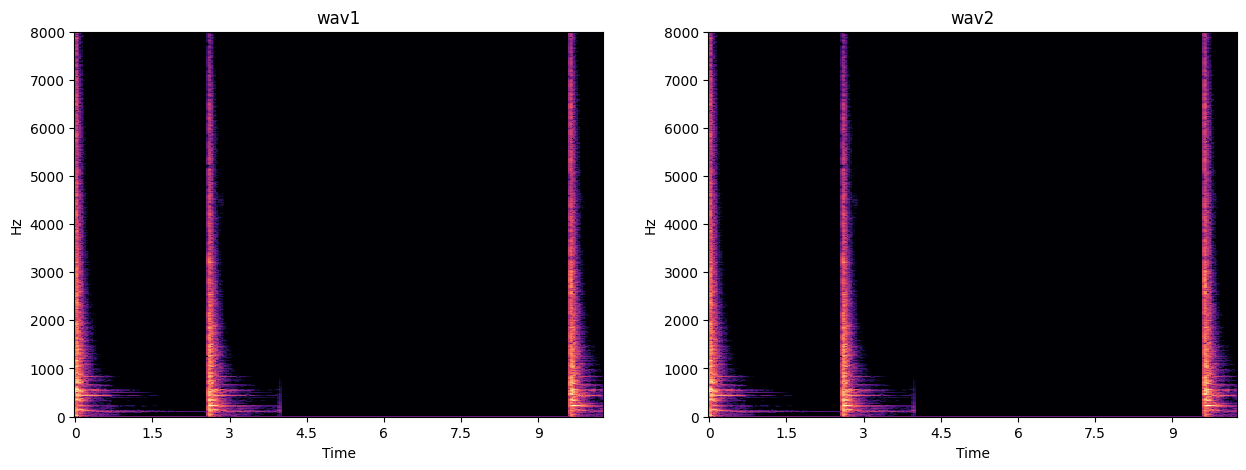

In [135]:
text = "A drumstick is continuously hitting a hard metal surface in a large room."

# semantic_edit_text = "An extremely dull or muffled sound with many low frequency components"
# semantic_edit_text = "muffled or dull"
semantic_edit_text = "An extremely bright sound with many high frequency components"


text = [text] * batch_size
batch = {
        "text": text,  # list
        "semantic_edit_text": semantic_edit_text
}

predicted_mel, predicted_wav, predicted_noise, predicted_uncond_noise, \
predicted_mel_orig, predicted_wav_orig,  predicted_semanticcond_noise, predicted_noise_with_cfg, intermediates = sample_diffusion_with_sega(batch)
plot_wavs(predicted_wav, predicted_wav_orig) 

In [136]:
len(intermediates['x_prev'])

22

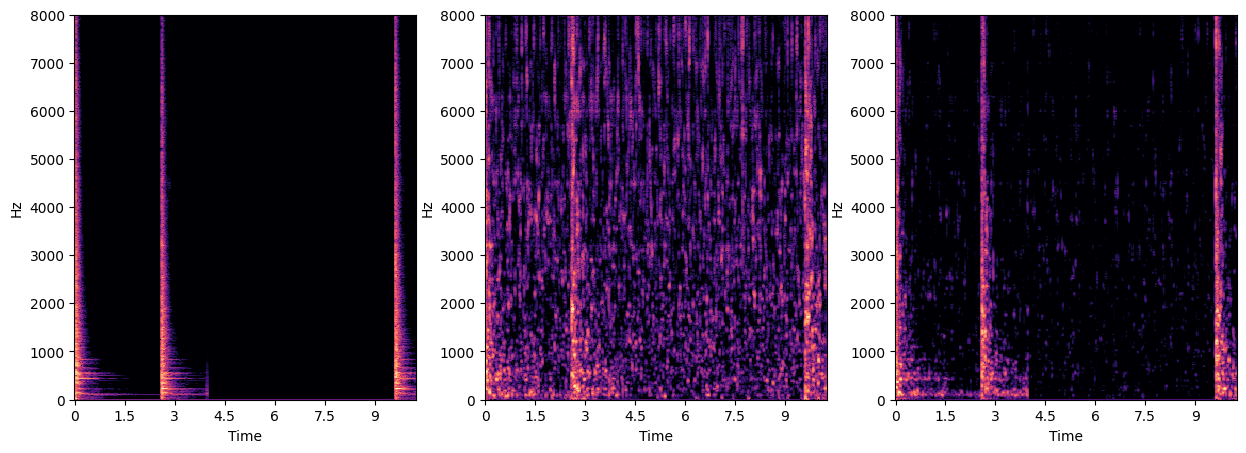

In [138]:
plot(predicted_wav, intermediates["x_prev"][11], intermediates["x_prev"][15])

In [109]:
torch.max(predicted_semanticcond_noise),torch.min(predicted_semanticcond_noise)

(tensor(4.3059, device='cuda:0'), tensor(-3.7603, device='cuda:0'))

In [33]:
torch.max(predicted_semanticcond_noise), torch.min(predicted_semanticcond_noise)

(tensor(4.0006, device='cuda:0'), tensor(-3.6482, device='cuda:0'))

In [27]:
a = torch.randn((1,8,256,64))
# print(a)
a_q = torch.quantile(torch.abs(a), 0.95, dim=3, keepdim=False) 
a_q, a_q.shape

(tensor([[[1.6619, 1.7717, 1.7212,  ..., 2.3427, 1.9428, 2.3648],
          [1.6428, 2.1610, 2.2052,  ..., 2.0096, 2.2213, 2.0196],
          [2.0318, 1.8497, 2.2265,  ..., 2.0257, 2.2962, 1.9620],
          ...,
          [1.8219, 1.9209, 2.0448,  ..., 1.8704, 1.9388, 1.7026],
          [1.8532, 1.8507, 1.9930,  ..., 2.0998, 1.5736, 1.8507],
          [1.6173, 1.9449, 1.8922,  ..., 1.9910, 2.1331, 1.6061]]]),
 torch.Size([1, 8, 256]))

In [28]:
a_edited = torch.where(
                            torch.abs(a) >= a_q[:, :, :, None],
                            a,
                            torch.zeros_like(a),
                        )

a_edited = torch.where(
                            torch.abs(a_edited) >= 2,
                            a_edited,
                            torch.zeros_like(a_edited),
                        )
a_edited, a_edited.shape

(tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  2.3622,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  2.3546],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000, -2.7127,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  2.2457],
           [ 0.0000,  0.0000,  2.2228,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 

In [ ]:
tmp = torch.quantile(
                                torch.abs(noise_guidance_edit_tmp).flatten(start_dim=2).to(torch.float32),
                                edit_threshold_c,
                                dim=2,
                                keepdim=False,
                            ).to(noise_guidance_edit_tmp.dtype)

                        noise_guidance_edit_tmp = torch.where(
                            torch.abs(noise_guidance_edit_tmp) >= tmp[:, :, None, None],
                            noise_guidance_edit_tmp,
                            torch.zeros_like(noise_guidance_edit_tmp),
                        )
                        noise_guidance_edit[c, :, :, :, :] = noise_guidance_edit_tmp